<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/S12_PartB_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/S12-AnchorBoxes/')

In [3]:
%cd /content/gdrive/My Drive/S12-AnchorBoxes
!ls

/content/gdrive/My Drive/S12-AnchorBoxes
Annotations_bounded.json  Images


# Load the downloaded json file (coco format) 

In [5]:
import numpy as np
import json
import pprint

json_path = "./Annotations_bounded.json"
with open(json_path, 'r') as f:
			robots_annotations = json.load(f)
print(robots_annotations.keys(), "\n")
pprint.pprint(robots_annotations["images"][0])
print()
pprint.pprint(robots_annotations["annotations"][0])
print()
pprint.pprint(robots_annotations["categories"][0])

dict_keys(['info', 'images', 'annotations', 'licenses', 'categories']) 

{'date_captured': '',
 'file_name': 'n02085782_2.jpg',
 'height': 298,
 'id': 0,
 'license': 1,
 'width': 414}

{'area': 71416,
 'bbox': [47, 35, 316, 226],
 'category_id': 1,
 'id': 0,
 'image_id': '0',
 'iscrowd': 0,
 'segmentation': [47, 35, 363, 35, 363, 261, 47, 261]}

{'id': 1, 'name': 'dog', 'supercategory': 'class'}


# Description of Json fields

# Images Key
**images.file_name** => name of image that is loaded for annotation\
**images.id** => unique id assigned by the tool \
**images.height** => Represents the height of the image file \
**images.width** => Represents total width of the image file \

# annotations key
**annotations.bbox **=> Array having X-Coord, Y-Coord, Width , Height of the bounding Box \
**annotations.image_id** => Image Id to which this bbox belongs to \
**annotations.area** => Total area of the bounding box \

In [0]:
#Parse and store the data in dict
import pandas

data = {}
for val in robots_annotations["images"]:
  data[val["id"]] = {
    'name': val["file_name"],
    'height': val["height"], 
    'width': val["width"],
  }
  
classes = {}
for val in robots_annotations["categories"]:
  classes[val["id"]] = val["name"]

for val in robots_annotations["annotations"]:
  data[int(val["image_id"])]["class"] = classes[val["category_id"]]
  data[int(val["image_id"])]["bbox"] = val["bbox"]



df_data = {
  "img_name": [],
  "class": [],
  "img_h": [],
  "img_w": [],
  "bbox_x": [],
  "bbox_y": [],
  "bbox_h": [],
  "bbox_w": [],
  "bbox_norm_x": [],
  "bbox_norm_y": [],
  "bbox_norm_w": [],
  "bbox_norm_h": [],
}
norm_bbox = []
for val in data.values():
  df_data["img_name"].append(val["name"])
  df_data["class"].append(val["class"])
  df_data["img_h"].append(val["height"])
  df_data["img_w"].append(val["width"])
  df_data["bbox_x"].append(val["bbox"][0])
  df_data["bbox_y"].append(val["bbox"][1])
  df_data["bbox_h"].append(val["bbox"][2])
  df_data["bbox_w"].append(val["bbox"][3])
  df_data["bbox_norm_x"].append(val["bbox"][0]/val["width"])
  df_data["bbox_norm_y"].append(val["bbox"][1]/val["height"])
  df_data["bbox_norm_w"].append(val["bbox"][2]/val["width"])
  df_data["bbox_norm_h"].append(val["bbox"][3]/val["height"])
  norm_bbox.append((df_data["bbox_norm_w"][-1],
        df_data["bbox_norm_h"][-1]))

df = pandas.DataFrame(df_data)
df.to_csv('./bounded_annotations.csv')



norm_bbox = np.array(norm_bbox)
log_bboxes = norm_bbox.copy()
log_bboxes = np.log(log_bboxes)




In [14]:
print(df.head())

           img_name class  img_h  ...  bbox_norm_y  bbox_norm_w  bbox_norm_h
0   n02085782_2.jpg   dog    298  ...     0.117450     0.763285     0.758389
1  n02085782_17.jpg   dog    425  ...     0.268235     0.819338     0.578824
2  n02085782_23.jpg   dog    379  ...     0.026385     0.625000     0.635884
3  n02085782_28.jpg   dog    283  ...     0.024735     0.709333     0.897527
4  n02085782_38.jpg   dog    379  ...     0.023747     0.506250     0.503958

[5 rows x 12 columns]


**Apply K Means to the normalized width and height calculated**

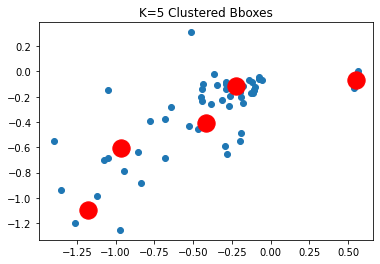

In [17]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

k = 5

X = log_bboxes
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300,
        n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
plt.scatter(X[:,0], X[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
      s=300, c='red')
plt.title("K=%s Clustered Bboxes" % k)
plt.savefig("k%s_clustered_bboxes.png" % k)
plt.show()



**WCSS and Elbow Method for K Means**

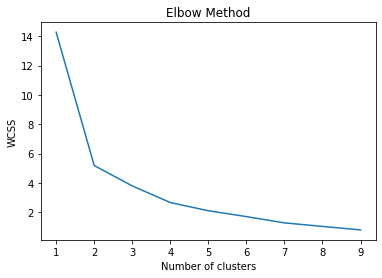

In [19]:
X = log_bboxes
wcss = []
for i in range(1, 10):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300,
          n_init=10, random_state=0)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()